In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from go_metric.data_utils import *
import matplotlib.pyplot as plt

In [67]:
train_path = "/home/andrew/go_metric/data/go_bench"
train_dataset = TermDataset.from_pickle(f"{train_path}/train.pkl")
val_dataset = TermDataset.from_pickle(f"{train_path}/val.pkl")
train_sampler = TermSampler(torch.BoolTensor(train_dataset.seq_dataset.labels.todense()), negative_ratio=3)
val_sampler = TermSampler(torch.BoolTensor(val_dataset.seq_dataset.labels.todense()), validation=True)

In [68]:
train_labels = train_dataset.seq_dataset.labels.toarray()
term_frequencies = train_labels.sum(axis=0)

In [70]:
train_sampler = TermSampler(torch.BoolTensor(train_dataset.seq_dataset.labels.todense()), negative_ratio=5)
train_samples = np.array(list(a.numpy() for a in train_sampler))
print(train_samples.shape)

(454320, 2)


In [72]:
ispos = train_labels[train_samples[:, 0], train_samples[:, 1]] > 0
print(ispos.shape)
pos_samples = train_samples[ispos, 1]
neg_samples = train_samples[~ispos, 1]
pos_ind, pos_counts = np.unique(pos_samples, return_counts=True)
n = np.zeros(term_frequencies.shape)
n[pos_ind] = pos_counts
pos_counts = n
neg_ind, neg_counts = np.unique(neg_samples, return_counts=True)
n = np.zeros(term_frequencies.shape)
n[neg_ind] = neg_counts
neg_counts = n

(454320,)


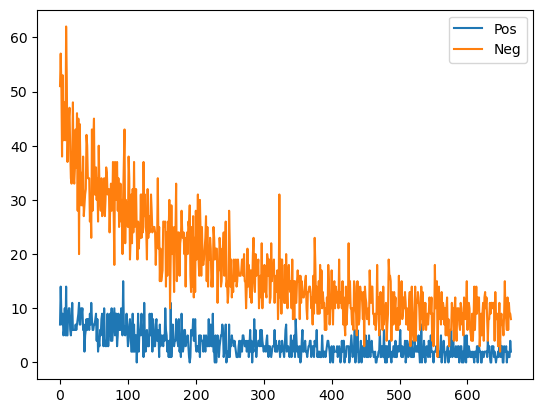

In [12]:
plt.plot(np.array([pos_counts[200:], neg_counts[200:]]).T)
plt.legend(["Pos", "Neg"])

In [46]:
import torch.utils.data as data
class TermSampler(data.Sampler):
    def __init__(self, labels, negative_ratio=4.0, validation=False):
        self.N, self.C = labels.shape
        self.negative_ratio = negative_ratio
        self.term_frequences = labels.sum(dim=0)
        self.term_weights = 1 / (self.term_frequences**0.5) #Totally made up. Upsample rare classes a bit.  
        self.pos_entries = torch.nonzero(labels) #(N, 2)
        self.pos_weights = self.term_weights[self.pos_entries[:, 1]]
        self.epoch_samples = int(self.pos_entries.shape[0]*0.1*(1+negative_ratio))

        self.validation = validation
        if(validation):
            N, C = self.N, self.C
            nneg = int(self.negative_ratio*N)
            neg_entries = torch.cat([torch.randint(0, N, (nneg, 1)), torch.randint(0, C, (nneg, 1))], dim=1)
            entries = torch.cat([self.pos_entries, neg_entries], dim=0)
            self.entries = entries
            
    def __iter__(self):
        if(self.validation):
            return (self.entries[i, :] for i in range(self.entries.shape[0]))
        N, C = self.N, self.C
        nneg = int(self.negative_ratio/(1+self.negative_ratio)*self.epoch_samples)
        neg_terms = torch.multinomial(self.term_frequences*self.term_weights, nneg, replacement=True).view(-1, 1)
        neg_entries = torch.cat([torch.randint(0, N, (nneg, 1)), neg_terms], dim=1)
        pos_sample_inds = torch.multinomial(self.pos_weights, int(self.pos_entries.shape[0]*0.1), replacement=False)
        pos_samples = self.pos_entries[pos_sample_inds, :]
        entries = torch.cat([pos_samples, neg_entries], dim=0)
        return (entries[i, :] for i in range(entries.shape[0]))

train_sampler = TermSampler(torch.BoolTensor(train_dataset.seq_dataset.labels.todense()), negative_ratio=3)
train_samples = np.array(list(a.numpy() for a in train_sampler))
print(train_samples.shape)

(302880, 2)


In [64]:
train_samples = np.array(list(a.numpy() for a in train_sampler))
ispos = train_labels[train_samples[:, 0], train_samples[:, 1]] > 0
pos_samples = train_samples[ispos, 1]
neg_samples = train_samples[~ispos, 1]
pos_ind, pos_counts = np.unique(pos_samples, return_counts=True)
n = np.zeros(term_frequencies.shape)
n[pos_ind] = pos_counts
pos_counts = n
neg_ind, neg_counts = np.unique(neg_samples, return_counts=True)
n = np.zeros(term_frequencies.shape)
n[neg_ind] = neg_counts
neg_counts = n

N, C = train_labels.shape
base_neg_counts = N - term_frequencies
neg_weight = (base_neg_counts / (neg_counts + 1)) * (pos_counts / term_frequencies)

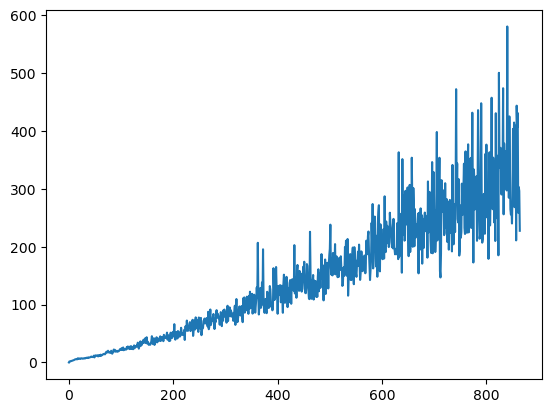

In [65]:
plt.plot(neg_weight)
plt.show()

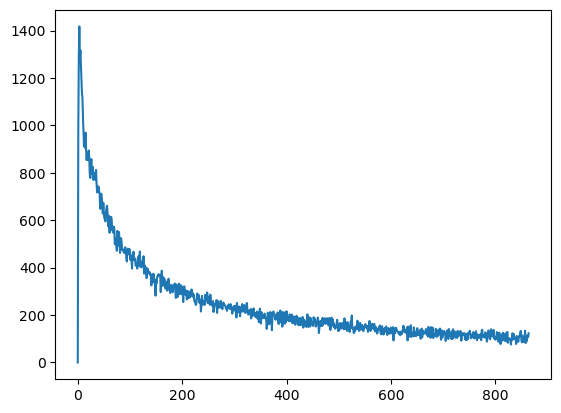

In [56]:
plt.plot(neg_counts)

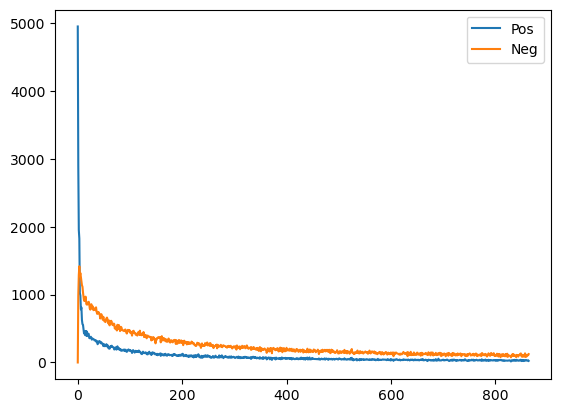

In [57]:
plt.plot(np.array([pos_counts, neg_counts]).T)
plt.legend(["Pos", "Neg"])